## Implementation of Inception V1 (GoogLeNet) on CIFAR-10 Dataset 

#### Group Member Names: 
1. Aiswarya Alapuzha (D19002)
2. Anugya Shaw (D19006) 
3. Ranjith Kothamasum (D19027) 
4. Soumya Srivastava (D19029)
5. Veera Shubhashree Putta (D19035) 

In [69]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Import Statement

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets , transforms
from torch.optim import lr_scheduler

from tqdm import tqdm

import random
import PIL 
from PIL import Image

from torch.autograd import Variable
from collections import OrderedDict
import math
from pathlib import Path
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version {torch.__version__}\nPIL version {PIL.__version__}\nDevice {device}")


torch version 1.4.0
PIL version 7.0.0
Device cuda


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL

## Objective
1. Get more than 90% accuracy
2. Minimum no of parameters
3. Max 30 Epochs
4. Use Data Augmentation
5. Experiment with regularizer

## Dataset

### Mean and Std calculation for Normalization

In [72]:
dataset = torchvision.datasets.CIFAR10(train=True,root="data/" , download=True)
mean = np.mean(dataset.data ,axis=(0,1,2))
std = np.std(dataset.data ,axis=(0,1,2))
print(f"\nMean is {mean}\nStd dev is  {std}")

Files already downloaded and verified

Mean is [125.30691805 122.95039414 113.86538318]
Std dev is  [62.99321928 62.08870764 66.70489964]


### Transformation and Dataset Defination

In [73]:
train_transforms = transforms.Compose([transforms.RandomCrop(size=32 , padding=4 , padding_mode="symmetric",pad_if_needed=True),
                                      transforms.RandomRotation((0,5),resample = PIL.Image.NEAREST),
                                      transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                       #transforms.Normalize(mean = mean , std=std)
                                      ])

val_transforms = transforms.Compose([transforms.ToTensor() , 
                                     #transforms.Normalize(mean=mean , std=std)
                                    ])

mean = torch.from_numpy(mean).type(torch.float32)
std = torch.from_numpy(std).type(torch.float32)

def denormalize(image):
  image = image.clone().detach().to("cpu") # take out of computational graph
  image = image.squeeze() 
  image = image.permute(1,2,0) # channel swapping H*W*C
 # image.mul_(std).add_(mean) # denormalize

  return image.numpy() 

trainset = torchvision.datasets.CIFAR10(train=True,root="data/" , download=True,transform=train_transforms)
valset  = torchvision.datasets.CIFAR10(train=False,root="data/" , download=True,transform=val_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Augmentation Visualization
side by side comparison of original Image and augmented Image

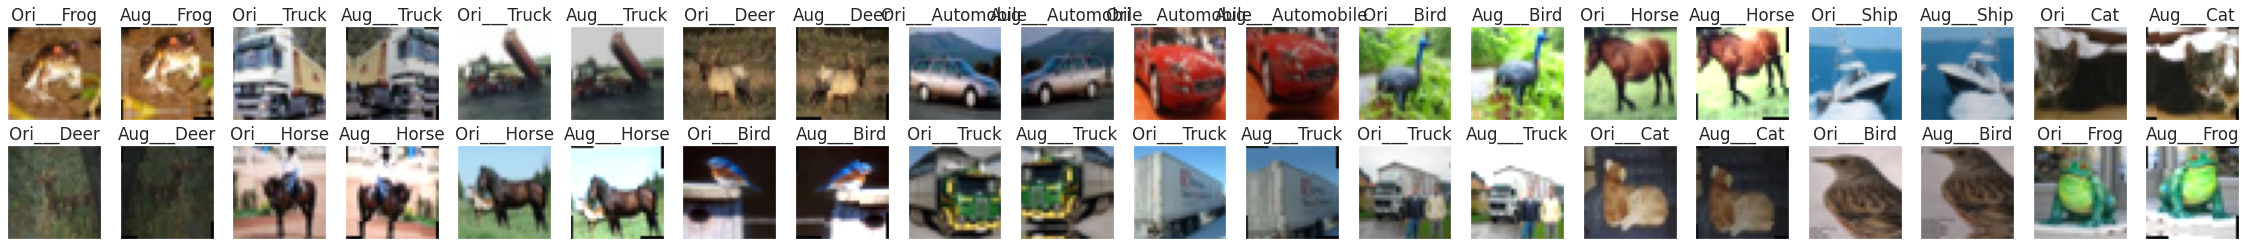

In [97]:
def show_img(ax,img,text):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.grid(False)
  ax.imshow(img)
  ax.set_title(text.title())

def visualizeAugmentation(augSet , normalset , no_of_images=8):
  """
    Visualizing Augmentation with normal set
    :augset : Augmented dataset
    :normalset :Normal dataset with no Augmentation
  """
  fig = plt.figure(figsize=(no_of_images*2,4))
  
  l = [x for x in range(1,2*no_of_images+1)] #indexing purpose 
  
  for i in range(no_of_images):
    
    ax  = fig.add_subplot(2,no_of_images,l[::2][i]) #odd numbers 
    ax2 = fig.add_subplot(2,no_of_images,l[1::2][i]) #even numbers
    
    show_img(ax , normalset[i][0],f"ori___{normalset.classes[normalset[i][1]]}")
    show_img(ax2 , denormalize(augSet[i][0]) , f"aug___{augSet.classes[augSet[i][1]]}")
  
visualizeAugmentation(trainset , dataset,no_of_images=20)

###  No grad


In [0]:
from functools import wraps

def no_grad(func):
  @wraps(func)
  def wrapper(*args,**kwargs):
    with torch.no_grad():
      return func(*args,**kwargs)
  return wrapper

### Save Checkpoint

In [0]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer,loss, best_loss, is_best,filepath=None):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    filename = Path("/gdrive/My Drive/GoogLeNet/checkpoint.pt") if filepath is None else filepath
    is_best = is_best if filepath is None else False
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state,   Path("/gdrive/My Drive/GoogLeNet/BEST_checkpoint.pt"))

## Model Definition - GoogLeNet

In [0]:
'''GoogLeNet with PyTorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )
        self.dropout = nn.Dropout(p=0.2)

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    #def forward(self, x):
        #y1 = self.dropout(F.relu(self.b1(x)))
        #y2 = self.dropout(F.relu(self.b2(x)))
        #y3 = self.dropout(F.relu(self.b3(x)))
        #y4 = self.dropout(F.relu(self.b4(x)))
        #return torch.cat([y1,y2,y3,y4], 1)

   
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)     


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)


        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 32, 32, 32, 32,  32,  32)
        self.d4 = Inception(128, 32, 32, 32, 32,  32,  32)
        self.e4 = Inception(128, 32, 160, 32, 32, 32, 32)

        self.a5 = Inception(128, 32, 160, 32, 32, 32, 32)
        self.b5 = Inception(128, 16, 192, 16, 16, 16, 16)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(64, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

According to our observation:
1. No. of filters in deeper layers(layers which are closer to output) are reduced.
2. No. Of filters in inner layers are kept high so that, we reduced overall parameters and increase the accuracy.
3. Also since the data has 10 classes so we tend to keep less no. of neurons in the output layer.

##  Parameters

In [0]:
batch_size=128
checkpoint = Path("/gdrive/My Drive/GoogLeNet/BEST_checkpoint.pt")
start_epoch = 0  # start at this epoch
epochs = 30  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader
lr = 0.01  # learning rate
weight_decay = 1e-4  # weight decay
n_classes = len(trainset.classes)

## DataLoader

In [0]:
loader_param = { "batch_size":batch_size,
                 "pin_memory":True,
                 "num_workers":workers,
                "shuffle":True}

trainLoader = DataLoader(trainset,**loader_param)

valLoader = DataLoader(valset  ,**loader_param)


## Averge Meter

In [0]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train method

In [0]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    :param optimizer :optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in train_loader:
      
        optimizer.zero_grad()
        # Move to default device
        images = images.to(device) 
        labels = labels.to(device)

        # Forward prop.
        output = model(images)  
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        
        loss.backward()
        
        
        optimizer.step()

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())
        
        # Print status
    print(f"TRAIN  Loss {losses.avg}\t Accuracy {accuracy.sum/len(train_loader.dataset)}")
    return losses.avg

## Validation method

In [0]:
@no_grad
def validate(val_loader, model, criterion):
    """
    One epoch's validation.

    :param val_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    """
    model.eval()  # inference mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in val_loader:

        # Move to default device
        images = images.to(device) 
        labels = labels.to(device)

        # Forward prop.
        output = model(images) 
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())
        

        # Print status
    print(f"VAL  Loss {losses.avg}\t Accuracy {accuracy.sum/len(val_loader.dataset)}")
    return losses.avg

## Training

In [0]:
from tqdm import trange
def main(epochs):
  """
  
  Training and validation.
  """
  global epochs_since_improvement, start_epoch, best_loss, checkpoint
  model = GoogLeNet() 
  model = model.to(device)

  # specify loss function (categorical cross-entropy)
  criterion = nn.CrossEntropyLoss()

  # specify optimizer
  optimizer = optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay,momentum=0.9,nesterov=True,dampening=0)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=4,min_lr=1e-5,verbose=True)
  
  # Initialize model or load checkpoint
  if checkpoint.exists():
    checkpoint_dict = torch.load(checkpoint)
    start_epoch = checkpoint_dict['epoch'] + 1
    epochs_since_improvement = checkpoint_dict['epochs_since_improvement']
    best_loss = checkpoint_dict['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model.load_state_dict(checkpoint_dict['model'])
    optimizer.load_state_dict(checkpoint_dict['optimizer']) 

  # Epochs
  for epoch in trange(start_epoch,start_epoch+epochs):
      print("Current LR is " , optimizer.param_groups[0]['lr'])
      # One epoch's training
      train_loss = train(train_loader=trainLoader,
                         model=model,
                         criterion=criterion,
                         optimizer=optimizer,
                         epoch=epoch)

      # One epoch's validation
      val_loss = validate(val_loader=valLoader,
                          model=model,
                          criterion=criterion)
      scheduler.step(val_loss)
      # Did validation loss improve?
      is_best = val_loss < best_loss
      best_loss = min(val_loss, best_loss)

      if not is_best:
          epochs_since_improvement += 1
          print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

      else:
          epochs_since_improvement = 0

      # Save checkpoint
      save_checkpoint(epoch, epochs_since_improvement, model, optimizer, train_loss, best_loss, is_best)
  return model

In [84]:
model = main(epochs=epochs)





  0%|          | 0/30 [00:00<?, ?it/s]

Current LR is  0.01
TRAIN  Loss 1.429385974559784	 Accuracy 0.48236
VAL  Loss 1.0239073263168335	 Accuracy 0.6343






  3%|▎         | 1/30 [01:36<46:34, 96.35s/it]

Current LR is  0.01
TRAIN  Loss 0.9030916484451293	 Accuracy 0.68268
VAL  Loss 0.7624542984008789	 Accuracy 0.7418






  7%|▋         | 2/30 [03:12<44:58, 96.37s/it]

Current LR is  0.01
TRAIN  Loss 0.7032909627914429	 Accuracy 0.7578
VAL  Loss 0.7248290587425232	 Accuracy 0.7535






 10%|█         | 3/30 [04:49<43:23, 96.43s/it]

Current LR is  0.01
TRAIN  Loss 0.5909843936538697	 Accuracy 0.79404
VAL  Loss 0.5946748448610306	 Accuracy 0.7949






 13%|█▎        | 4/30 [06:25<41:47, 96.45s/it]

Current LR is  0.01
TRAIN  Loss 0.5201105437660217	 Accuracy 0.82052






 17%|█▋        | 5/30 [08:02<40:10, 96.44s/it]

VAL  Loss 0.6304926807403565	 Accuracy 0.78

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.4693680156803131	 Accuracy 0.8399
VAL  Loss 0.5565625791072846	 Accuracy 0.8109






 20%|██        | 6/30 [09:38<38:35, 96.50s/it]

Current LR is  0.01
TRAIN  Loss 0.42635934408187864	 Accuracy 0.85298
VAL  Loss 0.433144926404953	 Accuracy 0.8549






 23%|██▎       | 7/30 [11:15<36:59, 96.52s/it]

Current LR is  0.01
TRAIN  Loss 0.3926756814575195	 Accuracy 0.86316






 27%|██▋       | 8/30 [12:51<35:22, 96.47s/it]

VAL  Loss 0.4681187909603119	 Accuracy 0.8465

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.35928649379730226	 Accuracy 0.87646
VAL  Loss 0.39039764194488524	 Accuracy 0.8676






 30%|███       | 9/30 [14:28<33:46, 96.49s/it]

Current LR is  0.01
TRAIN  Loss 0.3411161664390564	 Accuracy 0.88318






 33%|███▎      | 10/30 [16:04<32:08, 96.43s/it]

VAL  Loss 0.4404441742897034	 Accuracy 0.8552

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.3190418850660324	 Accuracy 0.8895






 37%|███▋      | 11/30 [17:41<30:32, 96.42s/it]

VAL  Loss 0.4150990989685059	 Accuracy 0.8634

Epochs since last improvement: 2

Current LR is  0.01
TRAIN  Loss 0.29891633949279783	 Accuracy 0.89704
VAL  Loss 0.3661092690467834	 Accuracy 0.8778






 40%|████      | 12/30 [19:17<28:55, 96.44s/it]

Current LR is  0.01
TRAIN  Loss 0.28063953513622286	 Accuracy 0.90384
VAL  Loss 0.3579596450805664	 Accuracy 0.8772






 43%|████▎     | 13/30 [20:54<27:20, 96.48s/it]

Current LR is  0.01
TRAIN  Loss 0.27073621070861814	 Accuracy 0.90658
VAL  Loss 0.3180833404541016	 Accuracy 0.8946






 47%|████▋     | 14/30 [22:30<25:45, 96.58s/it]

Current LR is  0.01
TRAIN  Loss 0.2517598822450638	 Accuracy 0.91402






 50%|█████     | 15/30 [24:07<24:08, 96.54s/it]

VAL  Loss 0.3411992202758789	 Accuracy 0.8847

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.2408657941675186	 Accuracy 0.91584






 53%|█████▎    | 16/30 [25:43<22:31, 96.53s/it]

VAL  Loss 0.3397342428445816	 Accuracy 0.8875

Epochs since last improvement: 2

Current LR is  0.01
TRAIN  Loss 0.22586841522216797	 Accuracy 0.9222






 57%|█████▋    | 17/30 [27:20<20:54, 96.50s/it]

VAL  Loss 0.3330430665016174	 Accuracy 0.8884

Epochs since last improvement: 3

Current LR is  0.01
TRAIN  Loss 0.21337097232818603	 Accuracy 0.92622






 60%|██████    | 18/30 [28:56<19:17, 96.49s/it]

VAL  Loss 0.39626521368026735	 Accuracy 0.873

Epochs since last improvement: 4

Current LR is  0.01
TRAIN  Loss 0.20210321183204652	 Accuracy 0.93038






 63%|██████▎   | 19/30 [30:33<17:41, 96.47s/it]

VAL  Loss 0.34810401182174683	 Accuracy 0.8888
Epoch    19: reducing learning rate of group 0 to 1.0000e-03.

Epochs since last improvement: 5

Current LR is  0.001
TRAIN  Loss 0.1390769912481308	 Accuracy 0.95358
VAL  Loss 0.2434208746910095	 Accuracy 0.9204






 67%|██████▋   | 20/30 [32:09<16:04, 96.44s/it]

Current LR is  0.001
TRAIN  Loss 0.11722209364414216	 Accuracy 0.96206
VAL  Loss 0.24045638861656188	 Accuracy 0.9248






 70%|███████   | 21/30 [33:45<14:27, 96.44s/it]

Current LR is  0.001
TRAIN  Loss 0.10955285401344299	 Accuracy 0.96472
VAL  Loss 0.2351992353439331	 Accuracy 0.9244






 73%|███████▎  | 22/30 [35:22<12:51, 96.48s/it]

Current LR is  0.001
TRAIN  Loss 0.10283132554888726	 Accuracy 0.96634






 77%|███████▋  | 23/30 [36:58<11:15, 96.44s/it]

VAL  Loss 0.23638021264076234	 Accuracy 0.924

Epochs since last improvement: 1

Current LR is  0.001
TRAIN  Loss 0.09792535170316696	 Accuracy 0.96856






 80%|████████  | 24/30 [38:35<09:38, 96.35s/it]

VAL  Loss 0.23937603178024291	 Accuracy 0.9246

Epochs since last improvement: 2

Current LR is  0.001
TRAIN  Loss 0.09405648550748825	 Accuracy 0.96994






 83%|████████▎ | 25/30 [40:11<08:01, 96.30s/it]

VAL  Loss 0.23810276646614076	 Accuracy 0.9241

Epochs since last improvement: 3

Current LR is  0.001
TRAIN  Loss 0.09176097666740418	 Accuracy 0.97106






 87%|████████▋ | 26/30 [41:47<06:25, 96.30s/it]

VAL  Loss 0.24075080208778382	 Accuracy 0.9233

Epochs since last improvement: 4

Current LR is  0.001
TRAIN  Loss 0.08817820062637328	 Accuracy 0.97222






 90%|█████████ | 27/30 [43:23<04:48, 96.29s/it]

VAL  Loss 0.23755506024360656	 Accuracy 0.9224
Epoch    27: reducing learning rate of group 0 to 1.0000e-04.

Epochs since last improvement: 5

Current LR is  0.0001
TRAIN  Loss 0.08280843736171722	 Accuracy 0.97394






 93%|█████████▎| 28/30 [45:00<03:12, 96.29s/it]

VAL  Loss 0.23850168919563294	 Accuracy 0.922

Epochs since last improvement: 6

Current LR is  0.0001
TRAIN  Loss 0.08024572853088378	 Accuracy 0.97564
VAL  Loss 0.23828219041824342	 Accuracy 0.9237

Epochs since last improvement: 7







 97%|█████████▋| 29/30 [46:36<01:36, 96.32s/it]

Current LR is  0.0001
TRAIN  Loss 0.08158503399252892	 Accuracy 0.97474






100%|██████████| 30/30 [48:12<00:00, 96.42s/it]

VAL  Loss 0.2359465404510498	 Accuracy 0.924

Epochs since last improvement: 8



## Per Class Accuracy

In [85]:
## load the model
@no_grad
def perClassAccuracy(model , classes):
  model = main(epochs=0)
  class_correct = np.zeros(len(classes) ,dtype =np.int64 )
  class_total = np.zeros_like(class_correct,dtype =np.int64 )
  model.eval()
  
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction == label:
        class_correct[prediction]+=1
      class_total[label]+=1
  per = np.round((100*class_correct/class_total) ,4)
  out = "\n".join([f"{name} :- {acc} %" for name ,acc in zip(classes , per)])
  return out+"\ntotal acc is {0}%".format(100* sum(class_correct)/sum(class_total))

print(perClassAccuracy(model , trainset.classes))





0it [00:00, ?it/s]


Loaded checkpoint from epoch 22. Best loss so far is 0.235.



airplane :- 93.3 %
automobile :- 96.6 %
bird :- 88.8 %
cat :- 83.5 %
deer :- 92.6 %
dog :- 87.9 %
frog :- 94.9 %
horse :- 94.7 %
ship :- 96.3 %
truck :- 95.8 %
total acc is 92.44%


Prediction of class cat is lowest and automobile is highest.
## Final Result :- 92.44 % Accuracy

## Visualizing the wrong prediction and where exactly model is confused

In [92]:
## load the model
model = main(epochs=0)
@no_grad
def allwrong_prediction(classes ,model):
  test_array =[]
  model.eval()
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction != label:
          test_array.append([data ,classes[prediction] ,classes[label]])
  return test_array

s = allwrong_prediction(trainset.classes , model)





0it [00:00, ?it/s]


Loaded checkpoint from epoch 22. Best loss so far is 0.235.



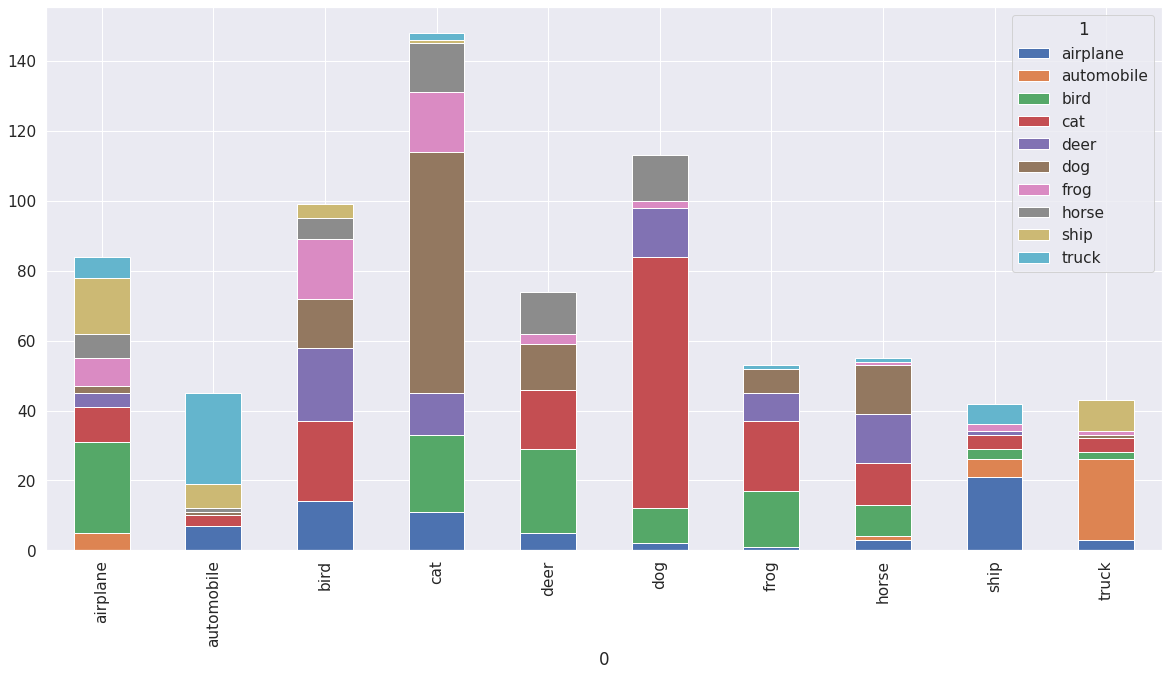

In [93]:
s_d = [(y,z) for x ,y,z in s]
df = pd.DataFrame(s_d)
gr = df.groupby([0,1])
gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,10))

## Inferencing Graph
 Model is confused between:
 1. Cat and Dog
 2. Automobile and truck

## Plot confusion matrix


In [94]:
from sklearn.metrics import classification_report, confusion_matrix
model = main(0)
pred = []
la=[]
with torch.no_grad():
  for image , label in valLoader:
    image , label = image.to(device) , label.to(device)
    output = model(image)
    output = F.softmax(output,dim=1)
    preds = torch.argmax(output,dim=1)
    pred.extend(preds.clone().detach().cpu().tolist())
    la.extend(label.clone().detach().cpu().tolist())






0it [00:00, ?it/s]


Loaded checkpoint from epoch 22. Best loss so far is 0.235.



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


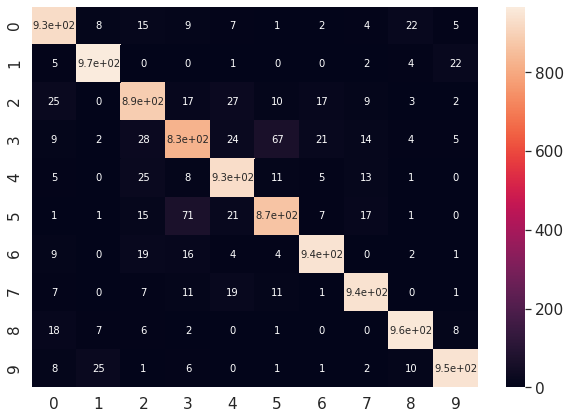

In [89]:
cm = confusion_matrix(la,
                      pred)
 
# Visualizing of confusion matrix
import seaborn as sn
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})# font size

## Parameters count

In [0]:
def count_parameters(model):
  pytorch_total_params = sum(p.numel() for p in model.parameters())
  print("Total_params",pytorch_total_params)
  pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("Trainable_params",pytorch_total_params)

In [96]:
count_parameters(model)

Total_params 1844082
Trainable_params 1844082
